# ENGR-E599: Autonomous Robotics
# Final Project Notebook
Ethan Eldridge, 12/17/21

---

This notebook file is meant to be an intuitive way to explain the code that was written for the project. Please feel free to contact me at etmeldr@iu.edu with any questions or concerns about this notebook. 

This project attempts to simulate the results of Garrett Leonard's 2014 thesis, "Localiaztion Using Kalman Filter with GPS and Wheel Encoders on a BCI Wheelchair." The paper is heavily referenced in the report associated with this notebook, and the system dynamics models and experimental methods implemented here are taken from the paper. Leonard's thesis can be found here: 

https://scholarworks.csun.edu/handle/10211.3/132976

## Simulating the Kalman Filter

The objective of this project was to use the Kalman filter, a powerful tool for signal processing, to enhance the postioning accuracy of California State University, Northridge's brain-computer interface (BCI) wheelchair. To achieve this, Leonard collected GPS and wheel encoder data from the wheelchair as it traveled down a series of pre-determined paths. Leonard then created a Kalman filtering program that took this position information and filtered out noise to give a more accurate reading of the wheelchair's true location. 

Given that the scope of this project was limited to a simulation of Leonard's results, actual GPS and wheel encoder information could not be obtained. Instead, the positioning data was synthesized using a random walk algorithm that used Leonard's proposed system dynamics to simulate a ground truth path for the wheelchair. This algorithm started the virtual wheelchair out at (0,0) and, for a given number of steps, generated wheel encoder speeds at each step. These encoder speeds were then plugged into the system dynamics equation in order to obtain a ground-truth $x$, $y$, and $\theta$ value for the virtual wheelchair at each step. 

The system dynamics for the wheelchair are as follows:

* - *

where $x(t)$ is the wheelchair's x-position at time $t$, $y(t)$ is the y-position, $\theta(t)$ is the orientation of the wheelchair relative to the x-axis, $V_R(t)$ is the right wheel's rotation speed in rad/s, and $V_L(t)$ is the left wheel's rotation speed. This dynamics model takes into account specific dimensions of the BCI wheelchair, such as the radius of each wheel, to derive an accurate measurement of the wheelchair's future state at time $t+1$. The dynamics model is derived from the more general Kalman filter state projection equation:

$\hat{x}^-_{t+1} = A\hat{x}_t + Bu_t$ 

where $\hat{x}^-_{t+1}$ is the system's state at time $t+1$, $\hat{x}_t$ is the system's state at time $t$, and $u_t$ is the input value to the system at time $t$. $A$ and $B$ are matrices specific to a given system dynamics model that transform the system input and former state of the system into a usable format for the projection equation. 

These system dynamics, as well as the $A$ and $B$ matrices for this dynamics model, were implemented in the algorithm $dynamics(V_L, V_R, \Delta t, lastEst)$, where the input $\Delta t$ is the change in time between estimates in seconds (defined consistently in this project as 1s), and $lastEst$ is a 1x3 matrix that contains the prior state of the system at time $t$. The output for $dynamics()$ is the new projected state of the system, $[x(t+1), y(t+1), \theta(t+1)]$ at time $t+1$. 



In [125]:
import numpy as np
import numpy.linalg as la
import random as rn
import math

# Prior state relation matrix
A = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

# Change in time at each step (seconds)
dt = 1

# Implementing system dynamics model
def dynamics(Vl, Vr, dt, lastEst):
    global A
    theta = lastEst[2]
    u = np.array([Vr, Vl])
    B = np.array([[0.5*dt*math.cos(math.radians(theta)), 0.5*dt*math.cos(math.radians(theta))],
                  [0.5*dt*math.sin(math.radians(theta)), 0.5*dt*math.sin(math.radians(theta))],
                  [(1/0.6985)*dt, -(1/0.6985)*dt]])
    state = np.matmul(A, lastEst)+np.matmul(B, u)
    return state

After the system dynamics had been implemented, it was possible to begin simulating the ground-truth path of the virtual wheelchair. The algorithm $simPath(steps)$ takes in an integer number of steps as input. For each step, simulating the passing of $\Delta t$ seconds in the wheelchair's trajectory, the algorithm decides the direction of the wheelchair's next movement by choosing one of three weighted directions: forward (F), right (R), and left (L). These directions are weighted at 0.95, 0.025, and 0.025, respectively, in order to simulate a more realistic path for the wheelchair than a purely random walk would. Although the filtering algorithm would still function on such a path, a spiraling and erratic trajectory would be much less common for a wheelchair to take than a more continuous path with a couple of major turns. 


Another feature adding to the realism of the path simulation is implementing adaptive changes to each direction's weight following decisions to turn. In the real world, once a vehicle initiates a turn, it usually continues to turn for several seconds more in order to orient itself in the direction it wants to turn. This cannot happen in the simulation with static weights, however, as the L and R weights are very low, making it improbable that the same turn would be selected again at the next step. This means that, when the "L" direction is selected for example, that the virtual wheelchair will turn only slightly to the left, and that the wheelchair will still be traveling in the general "forward" direction. It follows that in the entire trajectory of the wheelchair, only small changes to the orientation of the wheelchair would be made, and that no major turns would occur in the simulation. This is not the desired behavior for the simulation, as we would instead like to see the wheelchair make full 30º-90º turns from time to time to simulate a normal indoor or outdoor environment. To address this problem, at step $s$, the algorithm keeps track of the decision made at step $s-1$. If the last decision was "L" or "R," that decision is weighted significantly more. Although "F" is still the most probable option, it allows the simulation to recreate more realistic turns and behavior across all steps. 

Upon choosing a direction, the $simPath()$ algorithm then sets ground-truth encoder values for that step accordingly. If the choice was "L," for example, the right wheel would be traveling faster than the left wheel, so the encoder values reflect the difference in wheel speed. These values are then input into the $dynamics()$ algorithm to get ground truth $x, y,$ and $\theta$ values for that step. The $\theta$ value is then adjusted to reflect the orientation of the system dynamics model relative to the x-axis, and the ground truth state estimate and encoder values are finally recorded for the step. The algorithm then repeats this process for the remaining number of steps, recording the ground truth state estimates and encoder values at each step.  

$simPath()$ outputs two lists: $positions$ and $encoders$. These two lists represent the ground-truth $(x,y)$ positions and $(L,R)$ encoder values, respectively, of the simulated wheelchair along the generated path.

In [126]:
def simPath(steps):
    global dt, thetas
    Vl = 0
    Vr = 0
    actions = ["F", "R", "L"]
    weights = [0.95, 0.025, 0.025]
    estimates = [[0,0,0]]
    positions = [[0,0]]
    encoders = [[Vl, Vr]]
    last = "F"
    # For each step in the path
    for i in range(steps):
        # Adaptively updating weights for added path realism
        if last=="R":
            altered = [0.6, 0.3, 0.1]
            direction = rn.choices(actions, weights=altered, k=1)
        elif last =="L":
            altered = [0.6, 0.1, 0.3]
            direction = rn.choices(actions, weights=altered, k=1)
        else:
            direction = rn.choices(actions, weights=weights, k=1)
        # Generating encoder values according to decision
        if direction[0]=="F":
            last="F"
            Vl = 2
            Vr = 2
        elif direction[0]=="R":
            last="R"
            Vl = 3
            Vr = 1
        else:
            last="L"
            Vl = 1
            Vr = 3
        # Recording generated values
        encoders.append([Vl, Vr])
        results = dynamics(Vl, Vr, dt, estimates[i])
        # Correcting compass heading
        if results[2] < 0: results[2] = results[2] + 360
        estimates.append(results)
        positions.append(results[0:2])
    return positions, encoders


Each call of this function produces a different stochastically generated path. Below is a simulated 100-step path from the $simPath()$ algorithm. Feel free to change the $STEPS$ constant to generate longer or shorter paths. 

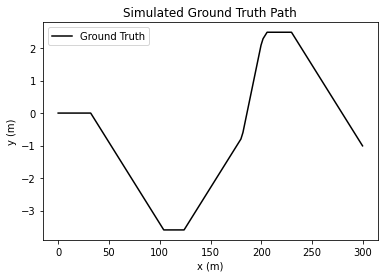

In [127]:
# Generating ground-truth position information
STEPS = 150

pos, enc = simPath(STEPS)

posX = [pos[i][0] for i in range(len(pos))]
posY = [pos[i][1] for i in range(len(pos))]

# Visualizing ground-truth position information
import matplotlib.pyplot as plt
plt.plot(posX, posY, color="black", label="Ground Truth")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Simulated Ground Truth Path")
plt.legend()
plt.show()

After the ground truth path had been generated for the virtual wheelchair, the positioning data needed to be generated for use in the filter. This was done using the following algorithm, $add\_noise(vals, stdev)$ which simply takes in a one-dimensional list of values and adds Gaussian noise to each value. The amount of noise added can be controlled via the $stdev$ parameter, which represets the standard deviation of the Gaussian distribution that the noise is drawn from. 

In [128]:
def add_noise(vals, stdev):
    noise = np.random.normal(0, stdev, len(vals))
    alt = np.array(vals)+noise
    return alt

Using this function, the program is able to take the ground truth position and encoder outputs from $simPath()$ and add Gaussian noise to them to represent the noisy GPS and wheel encoder values that the filter will be receiving. Noise for each sensor can be specified using the GPS_NOISE and ENC_NOISE parameters.

In [129]:
# Simulating noisy sensor data
GPS_NOISE = 0.25
gps = list(zip(add_noise(posX, GPS_NOISE), add_noise(posY, GPS_NOISE)))

ENC_NOISE = 0.0065
VL_noisy = add_noise([enc[i][0] for i in range(len(enc))], ENC_NOISE)
VR_noisy = add_noise([enc[i][1] for i in range(len(enc))], ENC_NOISE)
enc_noisy = list(zip(VL_noisy, VR_noisy))

With the noisy GPS data and wheel encoder values recreated, we can now take a look at the signals that the filter will be receiving and compare them to the ground truth path. The noisy GPS data can be plugged directly into the visualization given that it is alread in (x,y) position format. The noisy wheel encoder information, however, had to be ran back through the system dynamics model in order to calculate new (x,y) positions corresponding to the noisy encoder values at each path. These signals are visualized below. 

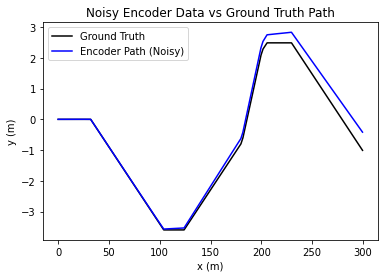

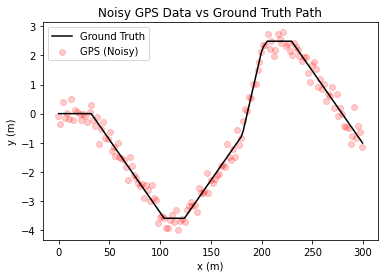

In [130]:
# Getting path generated from noisy encoders
estimates = [[0,0,0]]
enc_X = []
enc_Y = []
dyn = []
for i in range(len(VR_noisy)):
    res = dynamics(VL_noisy[i], VR_noisy[i], dt, estimates[i])
    estimates.append(res)
    enc_X.append(res[0])
    enc_Y.append(res[1])

# Visualizing noisy encoder data 
import matplotlib.pyplot as plt
plt.plot(posX, posY, color="black", label="Ground Truth")
plt.plot(enc_X, enc_Y, label="Encoder Path (Noisy)", color="blue")
plt.title("Noisy Encoder Data vs Ground Truth Path")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

# Visualizing noisy GPS data 
import matplotlib.pyplot as plt
plt.plot(posX, posY, color="black", label="Ground Truth")
plt.scatter([gps[i][0] for i in range(len(gps))], [gps[i][1] for i in range(len(gps))], color = "red", alpha = 0.2, label="GPS (Noisy)")
plt.title("Noisy GPS Data vs Ground Truth Path")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

Once all of the proper data had been generated, it was finally possible to implement the Kalman filter simulation itself. The implementation itself is relatively straightforward and deviates only slightly from the normal Kalman filter equation flow:



1. Get initial estimates for system state ($\hat{x}_t$) and error covariance matrix ($P_{t}$).
2. State projection: $\hat{x}^-_{t+1} = A\hat{x}_t + Bu_t$ 
3. Error covariance projection: $P^-_{t+1} = AP_{t}A^T+Q$
4. Kalman gain computation: $K_{t+1}=P^-_{t+1}H^T(HP^-_{t+1}H^T+R)^{-1}$
5. State projection update using measurement $z_{t+1}$ (GPS data): $\hat{x}_{t+1}=\hat{x}^-_{t+1}+K_{t+1}(z_{t+1}-H\hat{x}^-_{t+1})$
6. Error covariance update: $P_{t+1}=(I-K_{t+1}H)P^-_k$
*Repeat steps 2-6

The only modification to this order is an update of the value of $\theta$ during the state projection phase in order to make it align with the dynamic model's orientation relative to the x-axis. This modification, as well as each of the Kalman filter equations detailed above, is implemented below. 



In [131]:
# Measurement signal
z = gps

# State projection input
u = enc_noisy

N = len(gps)


#Initializing remaining matrices

#State-measurement relation matrix
C = np.array([[1, 0, 0],
              [0, 1, 0]])

#Process noise
Q = np.array([[1*(10**-9), 0, 0], 
              [0, 1*(10**-9), 0], 
              [0, 0, 1]])

#Measurement noise
R = np.array([[1*(10**-7), 0],
              [0, 1*(10**-7)]])

I = np.identity(3)


#Error Covariance
P_n = np.array([[1*(10**-9), 0, 0],
                [0, 1*(10**-9), 0],
                [0, 0, 1]])

def filter():
  global gps, P_n, C, I, R, Q, N, u, z
  #Initializing estimates to first GPS position 
  X = np.array([[gps[0][0], gps[0][1], 0]])

  # For each step
  for i in range(N):

      # Making adjustments for initialization case
      if i == 0:
          THETA = X[i][2]
      else:
          THETA = X[i-1][2]
      
      # Correcting compass heading 
      if THETA < 0: 
          THETA = THETA*-1
      else:
          THETA = 360-THETA

      # System dynamics input relation matrix
      B = np.array([[0.5*dt*math.cos(math.radians(THETA)), 0.5*dt*math.cos(math.radians(THETA))],
                    [0.5*dt*math.sin(math.radians(THETA)), 0.5*dt*math.sin(math.radians(THETA))],
                    [(1/0.6985)*dt, -(1/0.6985)*dt]])

      # State Prediction
      if i == 0:
          X[i] = np.matmul(A, X[i])+np.matmul(B, u[i])
      else:
          xhat = np.matmul(A, X[i-1])+np.matmul(B, u[i])
          X = np.append(X, [xhat], axis=0)        
          
      P = np.matmul(np.matmul(A, P_n), A.T)+Q

      # Correction
      K = np.matmul(np.matmul(P, C.T), la.inv(np.matmul(np.matmul(C, P), C.T)+R))
      X[i] = X[i] + np.matmul(K, (z[i] - np.matmul(C, X[i])))
      P = np.matmul((I-np.matmul(K, C)),P)

      P_n = P
  return X
  
X = filter()


We can now visualize the full simulation, including the ground truth path, the noisy GPS data, and the calculated filter path below. The noisy encoder path was excluded from this visualization as it would have convoluted the filter path and ground truth visualizations, though it was given its own plot earlier in the notebook. 

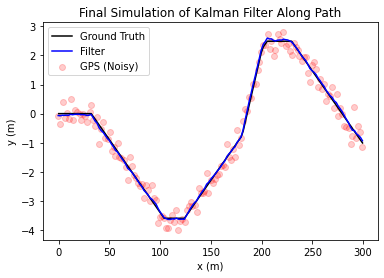

In [132]:
plt.plot(posX, posY, color="black", label="Ground Truth")
plt.plot([X[i][0] for i in range(len(X))], [X[i][1] for i in range(len(X))], label="Filter", color="blue")
plt.scatter([gps[i][0] for i in range(len(gps))], [gps[i][1] for i in range(len(gps))], color = "red", alpha = 0.2, label="GPS (Noisy)")
plt.title("Final Simulation of Kalman Filter Along Path")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

In addition to filtering data from a relatively signal-consistent wheelchair trajectory, Leonard's thesis also simulated a trajectory that passed through obstacles that would obstruct the wheelchair's GPS signal. This simulation was performed by adding Additional Gaussian noise to certain sections of the ground truth path. A similar implementation of this simulation can be found below, where each "dead zone" along the path is highlighted in red. 

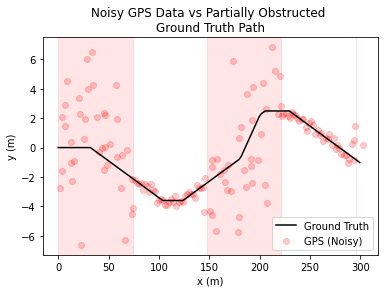

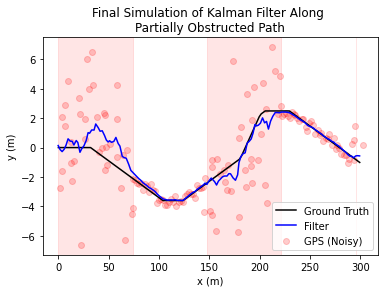

In [133]:
# Initializing obstruction noise
OBS_NOISE = GPS_NOISE*10
obs = list(zip(add_noise(posX, OBS_NOISE), add_noise(posY, OBS_NOISE)))

# Recreating path with partial GPS signal obstruction
final_gps = []
obstructed = False
# Keeping track of x-range that is obstructed
toggleX = []
for i in range(len(gps)):
  # Every 1/4 of the path, the signal obstruction is toggled
  point = int(STEPS/4)
  if i%point == 0: 
    obstructed = not(obstructed)
    toggleX.append(posX[i])
  if obstructed:
    final_gps.append(obs[i])
  else:
    final_gps.append(gps[i])


# Visualizing new GPS data
import matplotlib.pyplot as plt
plt.plot(posX, posY, color="black", label="Ground Truth")
plt.scatter([final_gps[i][0] for i in range(len(final_gps))], [final_gps[i][1] for i in range(len(final_gps))], color = "red", alpha = 0.2, label="GPS (Noisy)")
# Plotting dead zones
last = False
for x in range(len(toggleX)):
  if x+1 == len(toggleX):
    plt.axvspan(toggleX[x], toggleX[-1], color="red", alpha=0.1)
    break
  else:
    if last==False:
      plt.axvspan(toggleX[x], toggleX[x+1], color="red", alpha=0.1)
      last=True
    else:
      last = False
plt.title("Noisy GPS Data vs Partially Obstructed \nGround Truth Path")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

# Resetting measurement signal to newly compiled GPS data 
z = final_gps

X = filter()

# Visualizing new filtering process with obstructed signals 
plt.plot(posX, posY, color="black", label="Ground Truth")
plt.plot([X[i][0] for i in range(len(X))], [X[i][1] for i in range(len(X))], label="Filter", color="blue")
plt.scatter([final_gps[i][0] for i in range(len(final_gps))], [final_gps[i][1] for i in range(len(final_gps))], color = "red", alpha = 0.2, label="GPS (Noisy)")
# Plotting dead zones
last = False
for x in range(len(toggleX)):
  if x+1 == len(toggleX):
    plt.axvspan(toggleX[x], toggleX[-1], color="red", alpha=0.1)
  else:
    if last==False:
      plt.axvspan(toggleX[x], toggleX[x+1], color="red", alpha=0.1)
      last=True
    else:
      last = False
plt.title("Final Simulation of Kalman Filter Along \nPartially Obstructed Path")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()
  

  

